In [1]:
import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from collections import Counter, defaultdict

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from rdkit.Chem import MolToSmiles, MolFromSmiles
from tqdm import tqdm

In [3]:
data = pd.read_csv('Suzuki_rdkit_artificial_no_solventreagent_no_duplicates_30_70.tsv', sep='\t')


In [4]:
for col in properties.columns:
    print(col)

NameError: name 'properties' is not defined

In [5]:
data['property_C1']

0        11.297365
1        10.250014
2        11.378095
3        11.195533
4         9.286395
           ...    
54292     9.656214
54293     9.527969
54294    11.417345
54295    10.992350
54296    11.441508
Name: property_C1, Length: 54297, dtype: float64

In [61]:
y = data['yieldclass'].values
properties = data.drop(columns=['yieldclass', 'Component_1', 'Component_2', 'Product', 'property_C1', 'property_C2', 'property_P'])

In [6]:
def canonicalize_smiles(smiles):
    return MolToSmiles(MolFromSmiles(smiles), canonical=True)

In [7]:
molecules1 = set(data['Component_1'].unique())
molecules2 = set(data['Component_2'].unique())
products = set(data['Product'].unique())
all_mols = molecules1 | molecules2 | products
cleaned_mols = set(canonicalize_smiles(smiles) for smiles in tqdm(all_mols))
mol_id = {mol: i for i,mol in enumerate(sorted(cleaned_mols))}

100%|██████████| 75938/75938 [00:16<00:00, 4557.56it/s]


In [8]:
len(data['Component_1']) + len(data['Component_2']) + len(data['Product'])

162891

In [9]:
print(len(all_mols))
print(len(cleaned_mols))

75938
75874


In [10]:
mol_counts = Counter()
mol_counts.update(data['Component_1'])
mol_counts.update(data['Component_2'])
mol_counts.update(data['Product'])

In [111]:
mol_counts.most_common(10)

[('OB(O)C1=CC=CC=C1', 5693),
 ('COC1=CC=C(C=C1)B(O)O', 2707),
 ('CC1=CC=C(C=C1)B(O)O', 1505),
 ('OB(O)C1=CC=C(F)C=C1', 1179),
 ('OB(O)C1=CC=C(Cl)C=C1', 805),
 ('OB(O)C1=CC=C(C=C1)C(F)(F)F', 724),
 ('CC1=C(C=CC=C1)B(O)O', 709),
 ('OB(O)C1=CC=CS1', 641),
 ('OB(O)C1=CSC=C1', 632),
 ('COC1=CC=CC=C1B(O)O', 598)]

# How do molecules distribute according to yield class?

An important question is whether some molecules mainly occur in one of the two yield classes, here we define a measure of how concentrated a molecule is to yield class $1$ as:

$$
\frac{N_1}{N_0 + N_1}
$$

Essentially the mean class of a molecule. If the molecule occur about as much in positive as in negative reactions, this value will be close to $0.5$. If it mainly occurs in the positive class it will be close to $1$, while if it mainly occurs in a negative class it will be close to $0$. 

We can look how this score is distributed in our dataset. A dataset where there would be no bias due to the molecule would be distributed around 0.5, while a problematic dataset has its distribution concentrated at the values 0 and/or 1.

In [78]:
# First tally what classes the molecules occur in
class_mols = defaultdict(lambda: {0: 0, 1:0})
for record in tqdm(data.to_dict('records')):
    yield_class = record['yieldclass']
    for mol_key in ('Component_1', 'Component_2', 'Product'):
        smiles = canonicalize_smiles(record[mol_key])
        class_mols[smiles][yield_class] += 1

    

100%|██████████| 54297/54297 [00:26<00:00, 2031.24it/s]


In [152]:
class_mols

defaultdict(<function __main__.<lambda>()>,
            {'O=S(=O)(Oc1ccc2ccccc2c1)C(F)(F)F': {0: 7, 1: 0},
             'OB(O)c1ccccc1': {0: 5437, 1: 256},
             'c1ccc(-c2ccc3ccccc3c2)cc1': {0: 34, 1: 2},
             'Clc1cccc(I)c1': {0: 8, 1: 1},
             'Cc1ccc(B(O)O)cc1': {0: 1458, 1: 47},
             'Cc1ccc(-c2cccc(Cl)c2)cc1': {0: 1, 1: 0},
             'CSc1ccc(Br)cc1C#N': {0: 1, 1: 0},
             'OB(O)c1ccc(F)cc1': {0: 1129, 1: 50},
             'CSc1ccc(-c2ccc(F)cc2)cc1C#N': {0: 1, 1: 0},
             'C[C@H](C(=O)O[C@@H](C(=O)N1CCOCC1)c1ccccc1)c1ccc(I)c(F)c1': {0: 2,
              1: 0},
             'OB(O)c1cccc(O)c1': {0: 147, 1: 29},
             'C[C@H](C(=O)O[C@@H](C(=O)N1CCOCC1)c1ccccc1)c1ccc(-c2cccc(O)c2)c(F)c1': {0: 1,
              1: 0},
             'CN(C)c1ccc(Br)cc1C(F)(F)F': {0: 2, 1: 0},
             'OB(O)c1cccc(OCc2ccccc2F)c1': {0: 3, 1: 0},
             'CN(C)c1ccc(-c2cccc(OCc3ccccc3F)c2)cc1C(F)(F)F': {0: 1, 1: 0},
             'O=C(O)Cc1ccc

In [155]:
# Now calculate the mean class for each molecule
positive_fractions = {mol: class_counts[1] / (class_counts[0] + class_counts[1]) for mol, class_counts in class_mols.items() if (class_counts[0] + class_counts[1]) > 10}

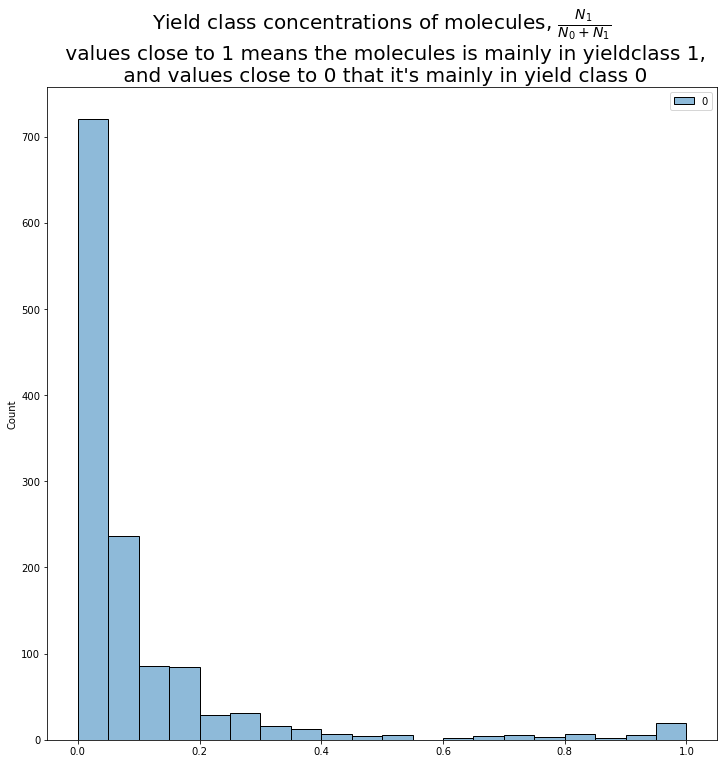

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
sns.histplot(positive_fractions.values(), bins=20)
plt.title("Yield class concentrations of molecules, $\\frac{N_1}{N_0 + N_1}$\n values close to 1 means the molecules is mainly in yieldclass 1,\n and values close to 0 that it's mainly in yield class 0", fontsize=20);

We can see that our dataset has a pronounced peak at 0, and a less pronounced peak at 1. This means that the vast majority of molecules occur only in one of the yield classes. This means that any statistical model will likely use this information when making its prediction, simply by looking at the identity of the molecules in the reaction.

# Predicting Yields without any chemical information

To test whether this works, we can create a new dataset where the feature of each molecule is simply a unique symbol. We can then use decision trees with support for categorical variables to test how well it can learn the yield classes from only a symbolic value for a molecule. You can think of replacing each molecule by a distinct nonsense-word which has no correlation to the molecules chemical properties. The only thing driving the statistical model will then be how often the molecule occurs in positive vs. negative reactinos

In [86]:
# Replace each molecule with its unique integer index
symbolic_reactions = data[['Component_1', 'Component_2', 'Product']].applymap(lambda x: mol_id[canonicalize_smiles(x)]).values

In [87]:
symbolic_reactions

array([[69301, 72252, 74192],
       [57022, 51594, 51017],
       [46375, 72030, 46307],
       ...,
       [31483, 40564, 31474],
       [ 2995, 46667,  2687],
       [ 9548, 32221, 32009]], dtype=int64)

In [150]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#X_train, X_validation, y_train, y_validation = train_test_split(properties.values, y, train_size=0.75, random_state=42)

model = CatBoostClassifier(
    #custom_loss=[metrics.Accuracy()],
    custom_metric=[metrics.BalancedAccuracy(), metrics.AUC(), metrics.Precision(), metrics.Recall()],
    random_seed=42,
    logging_level='Silent'
)
cv_params = model.get_params()
cv_params.update({
    'loss_function': metrics.Logloss(),
    'iterations': 2000
})
cv_data = cv(
    Pool(properties.values, y),
    cv_params,
    plot=True,
    stratified=True,
    fold_count=3
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [157]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_validation, y_train, y_validation = train_test_split(symbolic_reactions, y, train_size=0.75, random_state=42)

catergorical_feature_indices = [0,1,2]
model = CatBoostClassifier(
    #custom_loss=[metrics.Accuracy()],
    custom_metric=[metrics.Accuracy(), metrics.BalancedAccuracy(), metrics.AUC(), metrics.Precision(), metrics.Recall()],
    random_seed=42,
    logging_level='Silent'
)
cv_params = model.get_params()
cv_params.update({
    'loss_function': metrics.Logloss()
})
cv_data = cv(
    Pool(symbolic_reactions, y, cat_features=catergorical_feature_indices),
    cv_params,
    plot=True,
    stratified=True,
    fold_count=3
)
#model.fit(X_train, y_train, cat_features=catergorical_feature_indices, eval_set=(X_validation, y_validation), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Predicting yields from Random Vectors

A consequence of this is that as long as the features describing molecules are distinct enough, any statistical model will pick up on these. So even if we provide the model with chemically meaningful descriptors, the underlying sampling bias will drive much of the learning. It's not necessarily  the case that the actual descriptors are more useful than as unique identifiers. We can test this by essentially creating random vectors for each molecule. If you are familiar with NLP, you should see that this is very close to representing each molecule by an embedding vector.

In [15]:
n_mols = max(mol_id.values())+1
n_mols

75874

In [16]:
embedding_dim = 200
embedding_matrix = np.random.randn(n_mols, embedding_dim)

In [17]:
embedded_reactions = embedding_matrix[symbolic_reactions].reshape(-1, 3*embedding_dim)

In [18]:
embedded_reactions.reshape(-1, 3*embedding_dim).shape

(54297, 600)

In [ ]:
embedded_reactions = embedding_matrix[symbolic_reactions].sum(axis=1)

In [ ]:
data.loc[:, data.std() > 1e2].hist(bins=100, figsize=(16,8))

C:\Users\Erik\AppData\Local\Temp\ipykernel_24528\3186444372.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.loc[:, data.std() > 1e2].hist(bins=100, figsize=(16,8))


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:

data['Ipc_(C1_RDkit)'].apply(lambda x: np.log(x)).hist(bins=100)

KeyError: 'Ipc_(C1_RDkit)'

f:\Anaconda\envs\yield-prediction\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([[<AxesSubplot:title={'center':'Kappa1_(C1_rdkit)'}>,
        <AxesSubplot:title={'center':'Kappa2_(C1_rdkit)'}>,
        <AxesSubplot:title={'center':'Kappa3_(C1_rdkit)'}>],
       [<AxesSubplot:title={'center':'Kappa1_(C2_rdkit)'}>,
        <AxesSubplot:title={'center':'Kappa2_(C2_rdkit)'}>,
        <AxesSubplot:title={'center':'Kappa3_(C2_rdkit)'}>],
       [<AxesSubplot:title={'center':'Kappa1_(P_rdkit)'}>,
        <AxesSubplot:title={'center':'Kappa2_(P_rdkit)'}>,
        <AxesSubplot:title={'center':'Kappa3_(P_rdkit)'}>]], dtype=object)

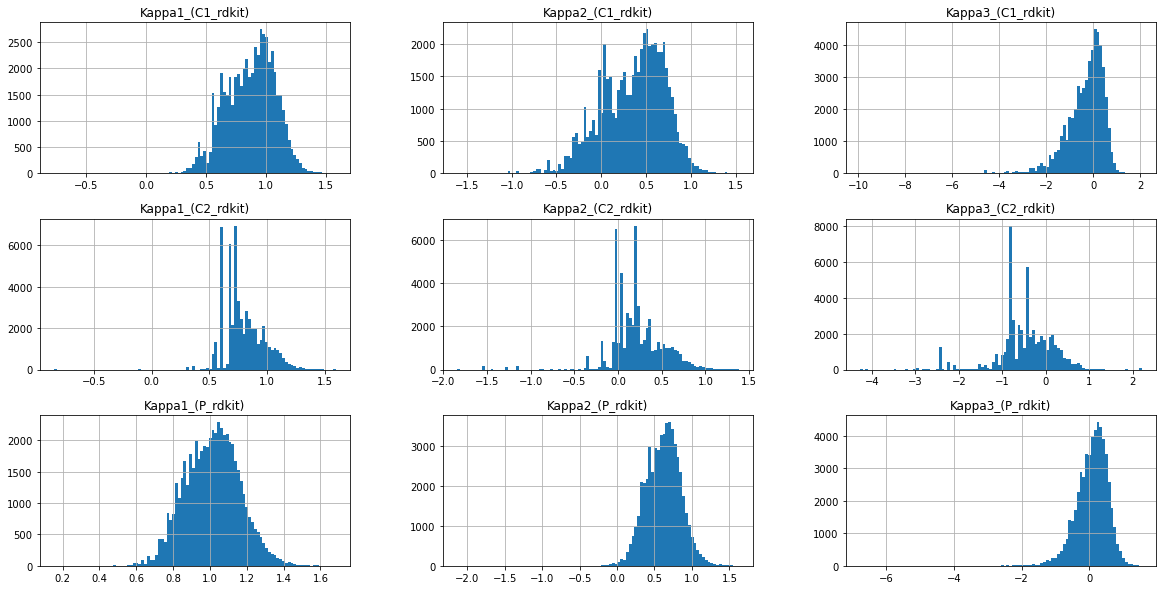

In [ ]:
data[[c for c in data.columns if 'Kappa' in c]].apply(lambda x: np.log(np.log(x))).hist(bins=100, figsize=(20, 10))

In [ ]:
log_log_columns = [c for c in data.columns if 'Kappa' in c or 'Ipc' in c]
log_log_columns

['Ipc_(C1_rdkit)',
 'Kappa1_(C1_rdkit)',
 'Kappa2_(C1_rdkit)',
 'Kappa3_(C1_rdkit)',
 'Ipc_(C2_rdkit)',
 'Kappa1_(C2_rdkit)',
 'Kappa2_(C2_rdkit)',
 'Kappa3_(C2_rdkit)',
 'Ipc_(P_rdkit)',
 'Kappa1_(P_rdkit)',
 'Kappa2_(P_rdkit)',
 'Kappa3_(P_rdkit)']

In [ ]:
data[log_log_columns] = data[log_log_columns].apply(lambda x: np.log(np.log(x)))

f:\Anaconda\envs\yield-prediction\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
X = X.drop(columns=log_log_columns)

NameError: name 'X' is not defined

In [ ]:
from collections import defaultdict

def do_cv_training(X,
                   y,
                   classifier,
                   num_splits=10,
                   metrics=("precision", 'recall', 'recall_weighted', "f1", "accuracy", "roc_auc", "roc_auc_ovo_weighted", "average_precision", "balanced_accuracy")
                  ):
        collected_metrics = {metric_name: [] for metric_name in metrics}
        scores = cross_validate(classifier, X, y, cv=num_splits, scoring=metrics)
        for metric_name in metrics:
            collected_metrics[metric_name].extend(scores["test_" + metric_name])
        return collected_metrics

In [ ]:
classifier = RandomForestClassifier(n_estimators=300,class_weight='balanced', n_jobs=14)

In [ ]:
classifier = GradientBoostingClassifier()

In [ ]:
classifier = LogisticRegression()

In [ ]:
y = data['yieldclass'].values

In [24]:
component_1_columns = symbolic_reactions[:,0]
component_2_columns = symbolic_reactions[:,1] + n_mols-1
product_columns = symbolic_reactions[:,2] + 2*(n_mols-1)

In [25]:
from scipy.sparse import lil_matrix

In [26]:
symbolic_reactions[:,0]

array([69301, 57022, 46375, ..., 31483,  2995,  9548], dtype=int64)

In [27]:
row_indices = np.arange(len(y))
reaction_matrix = lil_matrix((len(y), n_mols*3+3))
reaction_matrix[row_indices, component_1_columns] = 1
reaction_matrix[row_indices, component_2_columns] = 1
reaction_matrix[row_indices, product_columns] = 1


In [38]:
cv_data

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.665157,0.000061,0.665838,0.000032
1,1,0.639363,0.000312,0.640955,0.000178
2,2,0.614341,0.000203,0.616962,0.000142
3,3,0.591377,0.000230,0.594906,0.000207
4,4,0.570964,0.000329,0.575022,0.000163
...,...,...,...,...,...
995,995,0.240464,0.000812,0.258036,0.001190
996,996,0.240465,0.000814,0.258031,0.001191
997,997,0.240468,0.000813,0.258026,0.001192
998,998,0.240467,0.000815,0.258019,0.001197


In [22]:
do_cv_training(embedded_reactions, y, classifier, num_splits=5)

{'precision': [0.6792452830188679,
  0.75,
  0.7727272727272727,
  0.7307692307692307,
  0.6491228070175439],
 'recall': [0.029008863819500404,
  0.0265914585012087,
  0.0273972602739726,
  0.030620467365028204,
  0.029814665592264304],
 'recall_weighted': [0.8874769797421731,
  0.8877532228360958,
  0.8879270651072843,
  0.8879270651072843,
  0.8872824385302513],
 'f1': [0.055641421947449775,
  0.051361867704280154,
  0.05291828793774319,
  0.05877803557617942,
  0.05701078582434514],
 'accuracy': [0.8874769797421731,
  0.8877532228360958,
  0.8879270651072843,
  0.8879270651072843,
  0.8872824385302513],
 'roc_auc': [0.763435188498053,
  0.7615294199743508,
  0.7618612378851163,
  0.7528417121469633,
  0.7472057914509945],
 'roc_auc_ovo_weighted': [0.763435188498053,
  0.7615294199743508,
  0.7618612378851163,
  0.7528417121469633,
  0.7472057914509945],
 'average_precision': [0.3438266020541892,
  0.33367332583274345,
  0.3523437463246874,
  0.3267970257454841,
  0.3154706851902176]

In [23]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

NameError: name 'cv_data' is not defined

In [284]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.916256863932463


In [116]:
print(sorted(sklearn.metrics.SCORERS.keys()))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 'v_measure_score']


# Combating molecule sampling bias

One way to overcome this bias is to only include one reaction per molecule in the dataset.

In [125]:
i, (c1, c2, p) = next(data[['Component_1', 'Component_2', 'Product']].iterrows())

In [126]:
c1

'FC(F)(F)S(=O)(=O)OC1=CC2=C(C=CC=C2)C=C1'

In [128]:
molecules_to_reaction = defaultdict(lambda: defaultdict(set))
for i, (c1, c2, p) in tqdm(data[['Component_1', 'Component_2', 'Product']].iterrows()):
    label = y[i]
    for smiles in (c1, c2, p):
        smiles = canonicalize_smiles(record[col])
        molecules_to_reaction[label][smiles].add(i)

54297it [00:42, 1271.42it/s]


In [249]:
reaction_components = [(i, label, set([mol_id[canonicalize_smiles(smiles)] for smiles in smiles_list])) for i, (label, *smiles_list) in tqdm(data[['yieldclass', 'Component_1', 'Component_2', 'Product']].iterrows()) ]

54297it [00:30, 1795.77it/s]


In [271]:
def split_train_test_reactions(reaction_components, test_proportion=1.0, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    chosen_molecules = set()
    chosen_reactions = set()
    chosen_labels = Counter()

    rng = np.random.default_rng()

    reaction_index = np.arange(len(reaction_components))
    rng.shuffle(reaction_index)

    class_remainders = defaultdict(list)
    
    for i in tqdm(reaction_index):
        i, label, smiles_set = reaction_components[i]
        if not smiles_set & chosen_molecules:
            chosen_molecules.update(smiles_set)
            chosen_reactions.add(i)
            chosen_labels[label] += 1
        else:
            class_remainders[label].append(i)

    test_reactions = set()
    for label, count in chosen_labels.items():
        n_reactions = int(test_proportion * count)
        labeled_test_reactions = rng.choice(class_remainders[label], size=n_reactions, replace=False)
        test_reactions.update(labeled_test_reactions)

    return chosen_reactions, test_reactions

In [283]:
def make_symbolic_reactions(*reaction_dfs):
    unique_molecules = set()
    # First collect all molecules
    for reaction_df in reaction_dfs:
        for col in ('Component_1', 'Component_2', 'Product'):
            unique_molecules.update(canonicalize_smiles(smiles) for smiles in reaction_df[col].unique())
    mol_id = {smiles: i for smiles in enumerate(sorted(unique_molecules))}
    return [reaction_df[['Component_1', 'Component_2', 'Product']].applymap(lambda x: mol_id[canonicalize_smiles(x)])]


In [281]:
[canonicalize_smiles(smiles) for smiles in  data['Component_1'].unique()]

['O=S(=O)(Oc1ccc2ccccc2c1)C(F)(F)F',
 'Clc1cccc(I)c1',
 'CSc1ccc(Br)cc1C#N',
 'C[C@H](C(=O)O[C@@H](C(=O)N1CCOCC1)c1ccccc1)c1ccc(I)c(F)c1',
 'CN(C)c1ccc(Br)cc1C(F)(F)F',
 'O=C(O)Cc1cccc(Br)c1',
 'Brc1cncnc1',
 'BrCCCOc1ccccc1',
 'Cc1ccc(S(=O)(=O)N(C(=O)c2ccccc2)c2ccccc2)cc1',
 'CC(=O)Nc1ccc(F)cc1Br',
 'COc1ccc(-c2ncc(I)c(-c3ccccc3)c2C(=O)c2ccccc2)cc1',
 'O=Cc1ccc(Br)cc1',
 'C[C@@H](Nc1ncnc2c1c(I)cn2COCC[Si](C)(C)C)c1ccccc1',
 'N#Cc1ccc(I)cc1',
 'Brc1ccc(-c2ccc(Br)s2)s1',
 'Fc1ccc(Cl)cc1',
 'CCOP(=O)(OCC)Oc1ccc2ccccc2c1',
 'O=[N+]([O-])c1ccc(Br)cc1',
 'CN(C)c1snc2cc(Br)cnc12',
 'COc1ccc2c(c1)c(I)cn2S(=O)(=O)c1ccccc1',
 'COC(=O)/C=C1\\NC(=O)C(C)=C1Br',
 'Fc1ccc(Br)cc1',
 'CCOC(=O)/C=C(/CNC(=O)OCc1ccccc1)OS(=O)(=O)c1ccc(C)cc1',
 'CC/C(=C\\I)COCc1ccc(OC)cc1',
 'CC(=O)Nc1nc2ccc(Br)cc2s1',
 'NC(=O)[C@H]1CC[C@H](CNc2nc(Cl)cc(NCc3ccccc3)n2)CC1',
 'CCCCCCCCC1(CCCCCCCC)c2ccccc2-c2ccc(Br)cc21',
 'O=[N+]([O-])c1ccccc1Br',
 'Cc1cc(=O)oc2ccc(OS(=O)(=O)C(F)(F)F)cc12',
 'COC(=O)c1cc(C(C)(C)C)cc2c1Oc1c(

In [272]:
chosen_reactions, test_molecules = split_train_test_reactions(reaction_components)

100%|██████████| 54297/54297 [00:00<00:00, 987229.82it/s]


In [284]:
u_train, u_test = make_symbolic_reactions(data.iloc[sorted(chosen_reactions)], data.iloc[sorted(test_molecules)])

KeyError: 'COc1ccc(-c2ncc(I)c(-c3ccccc3)c2C(=O)c2ccccc2)cc1'

In [273]:
unique_reaction_subset = sorted(chosen_reactions)
unique_reaction_subset


[4,
 9,
 23,
 30,
 32,
 39,
 40,
 41,
 43,
 55,
 66,
 72,
 81,
 94,
 113,
 119,
 120,
 141,
 146,
 156,
 165,
 185,
 188,
 196,
 198,
 219,
 224,
 230,
 244,
 266,
 289,
 302,
 313,
 322,
 334,
 342,
 344,
 360,
 367,
 369,
 385,
 393,
 419,
 431,
 442,
 455,
 466,
 498,
 500,
 502,
 505,
 508,
 534,
 549,
 560,
 570,
 608,
 629,
 639,
 641,
 642,
 658,
 665,
 670,
 687,
 696,
 704,
 711,
 722,
 754,
 755,
 764,
 769,
 787,
 794,
 797,
 803,
 805,
 834,
 842,
 853,
 874,
 889,
 918,
 924,
 930,
 982,
 1010,
 1022,
 1040,
 1042,
 1044,
 1055,
 1065,
 1076,
 1080,
 1088,
 1105,
 1125,
 1129,
 1133,
 1152,
 1164,
 1172,
 1173,
 1181,
 1235,
 1236,
 1243,
 1260,
 1266,
 1286,
 1287,
 1291,
 1296,
 1297,
 1312,
 1313,
 1318,
 1321,
 1352,
 1413,
 1422,
 1434,
 1456,
 1457,
 1464,
 1475,
 1480,
 1494,
 1531,
 1590,
 1604,
 1619,
 1621,
 1625,
 1675,
 1683,
 1700,
 1713,
 1758,
 1772,
 1781,
 1797,
 1802,
 1807,
 1812,
 1839,
 1845,
 1888,
 1896,
 1899,
 1901,
 1906,
 1921,
 1927,
 1945,
 198

In [258]:
unique_reactions = data.iloc[unique_reaction_subset]

In [259]:
unique_reactions

,yieldclass,Component_1,Component_2,Product,property_P,property_C1,property_C2,MolLogP_(C1_rdkit),MolMR_(C1_rdkit),MolWt_(C1_rdkit),...,MQN33_(P_rdkit),MQN34_(P_rdkit),MQN35_(P_rdkit),MQN36_(P_rdkit),MQN37_(P_rdkit),MQN38_(P_rdkit),MQN39_(P_rdkit),MQN40_(P_rdkit),MQN41_(P_rdkit),MQN42_(P_rdkit)
4,0,CN(C)C1=CC=C(Br)C=C1C(F)(F)F,OB(O)C1=CC(OCC2=C(F)C=CC=C2)=CC=C1,CN(C)C1=C(C=C(C=C1)C1=CC(OCC2=C(F)C=CC=C2)=CC=...,21.316,9.286395,4.779728,3.53390,53.4710,268.076,...,0,0,0,3,0,0,0,0,0,0
9,0,CC(=O)NC1=C(Br)C=C(F)C=C1,OB(C1=CC(Cl)=C(Cl)C=C1)C1=CC=C(Cl)C(Cl)=C1,CC(=O)NC1=C(C=C(F)C=C1)C1=CC(Cl)=C(Cl)C=C1,3.148,10.706549,4.705935,2.54660,48.4037,232.052,...,0,0,0,2,0,0,0,0,0,0
23,0,CC\C(COCC1=CC=C(OC)C=C1)=C/I,CC[C@@H](\C=C(/CC)CO)[C@@H](OCOC)[C@H](C)\C=C(...,CC[C@@H](\C=C(/CC)C=O)[C@@H](OCOC)[C@H](C)\C=C...,20.997,10.298637,4.512120,3.94070,75.0440,332.181,...,0,0,0,1,0,0,0,0,0,0
32,0,NC1=CC=C(Cl)N=C1I,OB(O)C1=CC2=C(F)C=CC=C2N1,NC1=CC=C(Cl)N=C1C1=CC2=C(F)C=CC=C2N1,42.677,10.592522,4.804849,1.92180,46.3764,254.458,...,0,0,1,2,0,0,0,0,2,1
37,0,ClC1=CC=C(C=C1)C(=O)C1=CC=CC=C1,CC(=O)OC[B-](F)(F)F,OCC1=CC=C(C=C1)C(=O)C1=CC=CC=C1,46.493,10.859668,4.742911,3.57100,61.3265,216.667,...,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54260,0,CC1=CC2=CC(=CC(Br)=C2O1)C#N,CC(C)(C)OC(=O)C1=C(O)C=C(C=C1)B1OC(C)(C)C(C)(C)O1,CC1=CC2=CC(=CC(=C2O1)C1=CC(O)=C(C=C1)C(=O)OC(C...,10.097,10.178396,4.410485,3.37540,53.3660,236.068,...,0,0,1,2,0,0,0,0,2,1
54263,1,CC(=O)N1CCC2=C(C1)C(I)=NN2CC1CC1,CC1(C)OB(OC1(C)C)C1=CC=CC2=C1C=CN2,CC(=O)N1CCC2=C(C1)C(=NN2CC1CC1)C1=CC=CC2=C1C=CN2,3.078,10.661869,4.634257,1.80230,72.4630,345.184,...,1,0,2,2,0,0,0,0,4,2
54266,1,CNC(=O)C1=C(Br)C=CC=N1,CC1(C)OB(OC1(C)C)C1=CC=C(CCC(=O)NCCNS(=O)(=O)C...,CNC(=O)C1=C(C=CC=N1)C1=CC=C(CCC(=O)NCCNS(=O)(=...,23.572,9.797723,4.803503,1.20370,45.3272,215.050,...,0,0,0,4,0,0,0,0,2,1
54274,0,CC(=O)C1=NC(Br)=CC=C1,OB(O)C1=C(O)C=C(Cl)C=C1,CC(=O)C1=NC(=CC=C1)C1=C(O)C=CC(Cl)=C1,3.027,10.286742,4.847903,2.04670,41.9415,200.035,...,0,0,0,2,0,0,0,0,0,0


In [228]:
u_molecules1 = set(unique_reactions['Component_1'].unique())
u_molecules2 = set(unique_reactions['Component_2'].unique())
u_products = set(unique_reactions['Product'].unique())
u_all_mols = molecules1 | molecules2 | products
u_cleaned_mols = list(set(canonicalize_smiles(smiles) for smiles in tqdm(u_all_mols)))
np.random.shuffle(u_cleaned_mols)
u_mol_id = {mol: i for i,mol in enumerate(u_cleaned_mols)}


100%|██████████| 75938/75938 [00:16<00:00, 4556.35it/s]


In [229]:
u_mol_counts = Counter()
u_mol_counts.update(unique_reactions['Component_1'])
u_mol_counts.update(unique_reactions['Component_2'])
u_mol_counts.update(unique_reactions['Product'])

In [230]:
u_mol_counts.most_common(10)

[('ClC1=CC=CC(I)=C1', 2),
 ('BrC1=CC=C(S1)C1=CC=C(Br)S1', 2),
 ('CC(=O)NC1=NC2=C(S1)C=C(Br)C=C2', 2),
 ('[O-][N+](=O)C1=C(Br)C=CC=C1', 2),
 ('BrC1=CC=C(C=C1)C1=CN(N=N1)C(=O)N1CCCCC1CC1=CC=CC=C1', 2),
 ('COC1=CC=C(CN(C2CCCC2)S(=O)(=O)C2=CC(Br)=CC=C2OC)C(OC)=C1', 2),
 ('CC1=CC=C(C=C1)S(=O)(=O)N1C=CC2=C(Cl)N=CN=C12', 2),
 ('BrC1=CC=CS1', 2),
 ('CS(=O)(=O)C1=C(NC2=CC(Cl)=C3N=CC=NC3=C2)C=NC=C1', 2),
 ('CC1=CC=C(O)C(Br)=C1', 2)]

In [138]:
len(unique_reactions)

5254

In [260]:
u_y = unique_reactions['yieldclass'].values
u_properties = unique_reactions.drop(columns=['yieldclass', 'Component_1', 'Component_2', 'Product', 'property_C1', 'property_C2', 'property_P'])

In [261]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rng = np.random.default_rng(1729)
train_indices, test_indices = split_train_test_reactions(reaction_components, rng=rng)
#X_train, X_validation, y_train, y_validation = train_test_split(u_properties.values, u_y, train_size=0.8, random_state=42)

X_train = symbolic_reactions

model = CatBoostClassifier(
    #custom_loss=[metrics.Accuracy()],
    custom_metric=[metrics.Accuracy(), metrics.BalancedAccuracy(), metrics.AUC(), metrics.Precision(), metrics.Recall()],
    random_seed=42,
    logging_level='Silent'
)
cv_params = model.get_params()
cv_params.update({
    'loss_function': metrics.Logloss(),
    'iterations': 1000,
    'learning_rate': 1e-2
})
# cv_data = cv(
#     Pool(u_properties.values, u_y),
#     cv_params,
#     plot=True,
#     stratified=True,
#     fold_count=5,
# )
model.fit(X_train, y_train, eval_set=(X_validation, y_validation), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [262]:
# Replace each molecule with its unique integer index
u_symbolic_reactions = unique_reactions[['Component_1', 'Component_2', 'Product']].applymap(lambda x: u_mol_id[canonicalize_smiles(x)]).values

In [263]:
u_symbolic_reactions

array([[72011,  6185, 67607],
       [59139, 21493, 16814],
       [23424, 34902, 29682],
       ...,
       [ 1965, 69632, 71081],
       [71107, 69143,   625],
       [42369,  1784, 23963]], dtype=int64)

In [264]:
np.unique(u_symbolic_reactions, return_counts=True)

(array([    3,     7,    11, ..., 75862, 75865, 75870], dtype=int64),
 array([1, 1, 1, ..., 1, 1, 1], dtype=int64))

In [265]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_validation, y_train, y_validation = train_test_split(u_symbolic_reactions, u_y, train_size=0.75, random_state=42)

catergorical_feature_indices = [0,1,2]
model = CatBoostClassifier(
    #custom_loss=[metrics.Accuracy()],
    custom_metric=[metrics.Accuracy(), metrics.BalancedAccuracy(), metrics.AUC(), metrics.Precision(), metrics.Recall()],
    random_seed=42,
    logging_level='Silent',
    auto_class_weights='Balanced'
)
cv_params = model.get_params()
cv_params.update({
    'loss_function': metrics.Logloss()
})
# cv_data = cv(
#     Pool(u_symbolic_reactions, u_y, cat_features=catergorical_feature_indices),
#     cv_params,
#     plot=True,
#     stratified=True,
#     fold_count=3
# )
model.fit(X_train, y_train, cat_features=catergorical_feature_indices, eval_set=(X_validation, y_validation), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

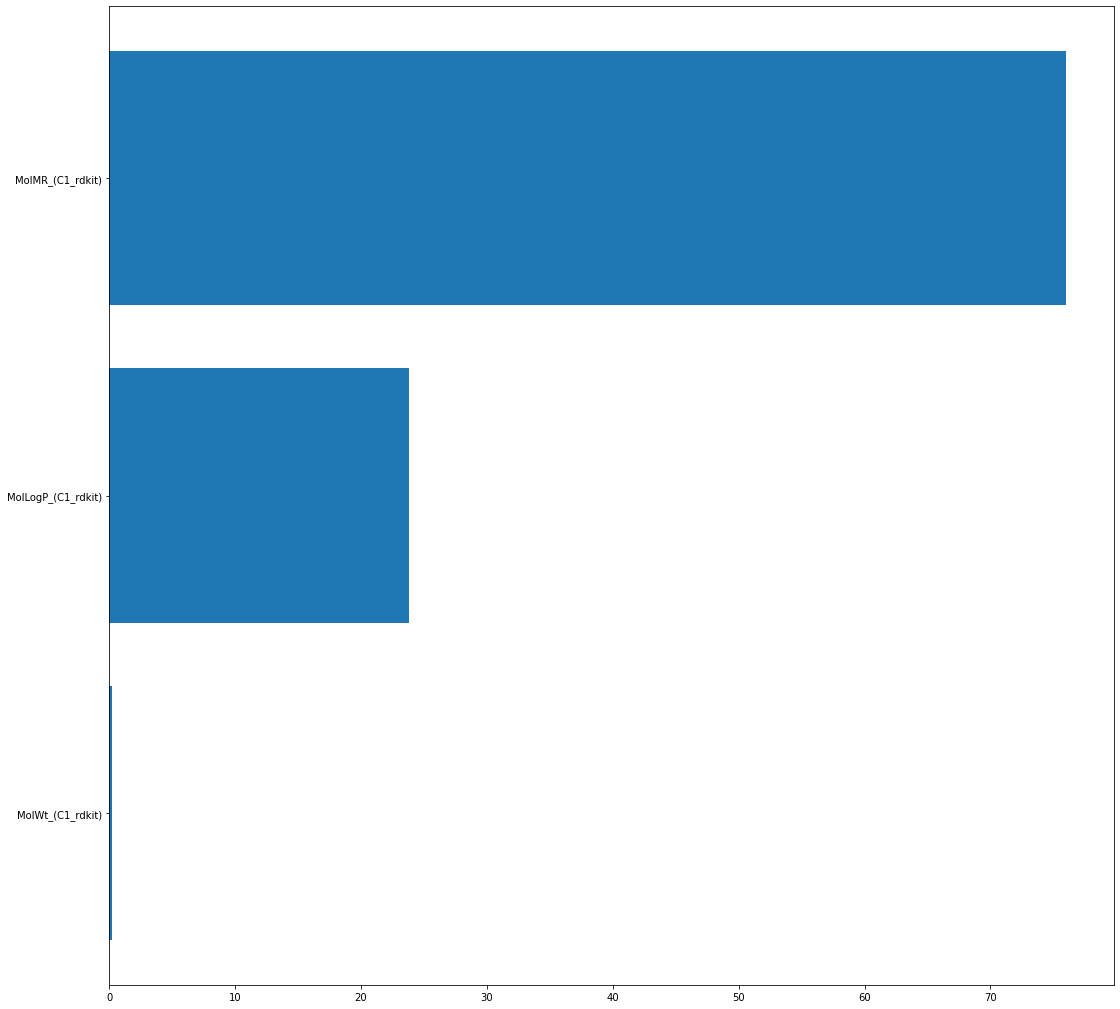

In [196]:
importances = model.get_feature_importance()
sort_order = np.argsort(importances)

top_k = 30
selected_indices = sort_order[-top_k:]
selected_importances = importances[selected_indices]
x = np.arange(len(selected_importances))
labels = [u_properties.columns[i] for i in selected_indices]
plt.figure(figsize=(18,18))
plt.barh(x, selected_importances)
plt.yticks(x, labels);